# Project 3: Implementing a Simple Recurrent Neural Network (RNN)

## Introduction

In this project, you will design, implement, and evaluate a simple Recurrent Neural Network (RNN) from scratch. This will involve building the entire pipeline, from data preprocessing to model training and evaluation.

## Objectives

1. Set up TensorFlow or PyTorch environments. You are free to choose your preferred DL platform.
2. Use GPU for training.
3. Create a data loader and implement data preprocessing where needed.
4. Design a Convolutional Neural Network.
5. Train and evaluate your model. Make sure to clearly show loss and accuracy values. Include visualizations too.
6. Answer assessment questions.

## Dataset

You are free to choose any dataset for this project! Kaggle would be a good source to look for datasets. Below are some examples:
- Daily Minimum Temperatures in Melbourne: This dataset contains the daily minimum temperatures in Melbourne, Australia, from 1981 to 1990.
- Daily Bitcoin Prices: This dataset contains historical daily prices of Bitcoin, which can be used for time series forecasting projects.
- Text8 Dataset: This dataset consists of the first 100 million characters from Wikipedia. It's great for text generation or language modeling tasks.
- IMDB Movie Reviews: This dataset contains 50,000 movie reviews for sentiment analysis, split evenly into 25,000 training and 25,000 test sets.
- Jena Climate Dataset: This dataset records various weather attributes (temperature, pressure, humidity, etc.) every 10 minutes, making it ideal for time series analysis.
- Earthquake Aftershocks: This dataset contains seismic data, suitable for predicting aftershocks following major earthquakes.


Required imports

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

DATA PREPROCESSING

In [49]:
# Load the dataset
data_csv = 'daily-minimum-temperatures-in-me.csv'

df = pd.read_csv(data_csv,
                 on_bad_lines='skip',
                 parse_dates=[0],
                 skiprows = [3652]) # skipping column with bad data

df.head()


,Date,"Daily minimum temperatures in Melbourne, Australia, 1981-1990"
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [50]:
# Rename column
df = df.rename(columns={'Daily minimum temperatures in Melbourne, Australia, 1981-1990' : 'Temp'})

df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


While looking at the csv dataset, some temperature values are not digits.

In [51]:
# Preprocess the data
not_digit_df = df[~df['Temp'].str[0].str.isdigit()]

not_digit_df

,Date,Temp
565,1982-07-20,?0.2
566,1982-07-21,?0.8
1290,1984-07-14,?0.1


Remove the question mark and convert the temperature to float

In [52]:
df['Temp'] = df['Temp'].apply(lambda x:x.replace('?', ''))

# Convert the temperature values in float
df['Temp'] = df['Temp'].astype(float)
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [53]:
# Set the Date to index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


Visualize the data

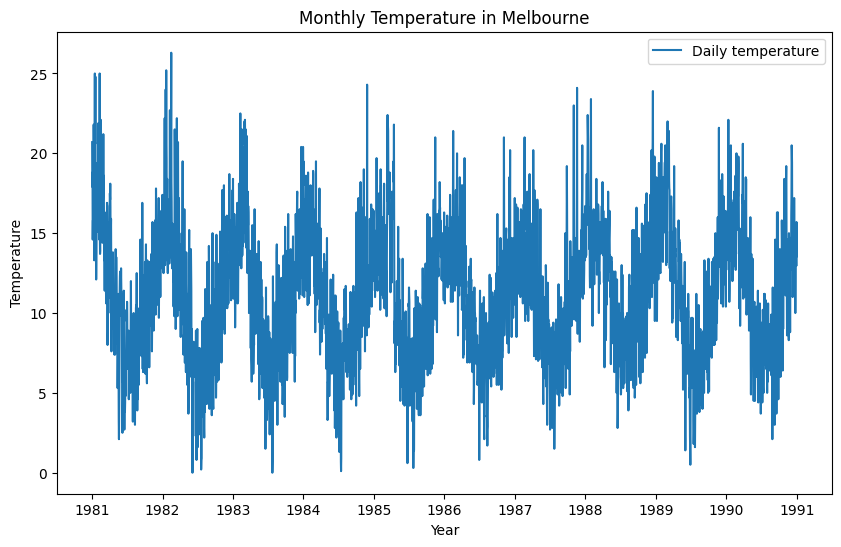

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(df, label='Daily temperature')
plt.title('Monthly Temperature in Melbourne')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [56]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(df)

In [57]:
def create_sequences(df, seq_length):
    xs, ys = [], []
    for i in range(len(df)-seq_length):
        x = df[i:i+seq_length]
        y = df[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 12
X, y = create_sequences(data_normalized, seq_length)

# Convert to PyTorch tensors
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

In [58]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [59]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTM, self).__init__()
        # Number of features in the input
        self.hidden_layer_size = hidden_layer_size
        # LSTM layer with input size (features) and hidden layer size (units)
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        # Fully connected linear layer that maps from hidden state to output
        self.linear = nn.Linear(hidden_layer_size, output_size)
        # Initialize hidden state and cell state with zeros
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        # input_seq.view is to reshape the input sequence for the LSTM layer
        # LSTM layer's expected input shape: (sequence_length, batch_size, input_size). Here, `sequence_length` is the length of the input sequence, `batch_size` is set to 1, and `input_size` is the number of features (1 in this example).
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        # lstm_out.view is to reshape the LSTM output for the linear layer
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        # Index -1 is to return the last prediction in the sequence
        return predictions[-1]

In [60]:
model = LSTM()
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [74]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100

for i in range(epochs):
    for seq, labels in zip(X_train, y_train):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%10 == 0:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   0 loss: 0.00645362
epoch:  10 loss: 0.00908082
epoch:  20 loss: 0.01242520
epoch:  30 loss: 0.01370969
epoch:  40 loss: 0.01448018
epoch:  50 loss: 0.01398153
epoch:  60 loss: 0.01253345
epoch:  70 loss: 0.01211993
epoch:  80 loss: 0.01036367
epoch:  90 loss: 0.00927444
epoch:  99 loss: 0.0109279118


Root Mean Squared Error: 2.4274672247177262


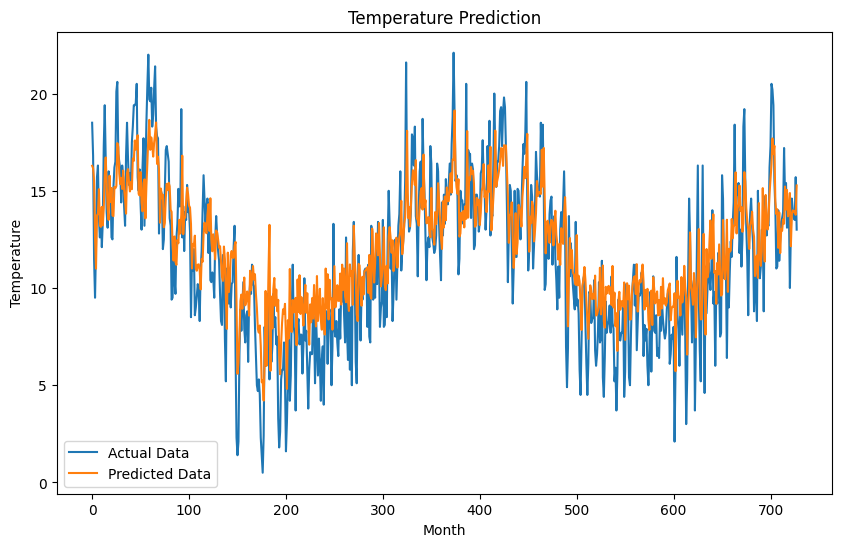

In [75]:
model.eval()
test_outputs = []

for seq in X_test:
    with torch.no_grad():
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
        test_outputs.append(model(seq).item())

test_outputs = scaler.inverse_transform(np.array(test_outputs).reshape(-1, 1))
actuals = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actuals, test_outputs))
print(f'Root Mean Squared Error: {rmse}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual Data')
plt.plot(test_outputs, label='Predicted Data')
plt.title('Temperature Prediction')
plt.xlabel('Month')
plt.ylabel('Temperature')
plt.legend()
plt.show()

Epochs: 10 - RMSE: 3.532916574039363

Epochs: 40 - RMSE: 2.6077445283679084

Epochs: 100 - RMSE: 2.4274672247177262

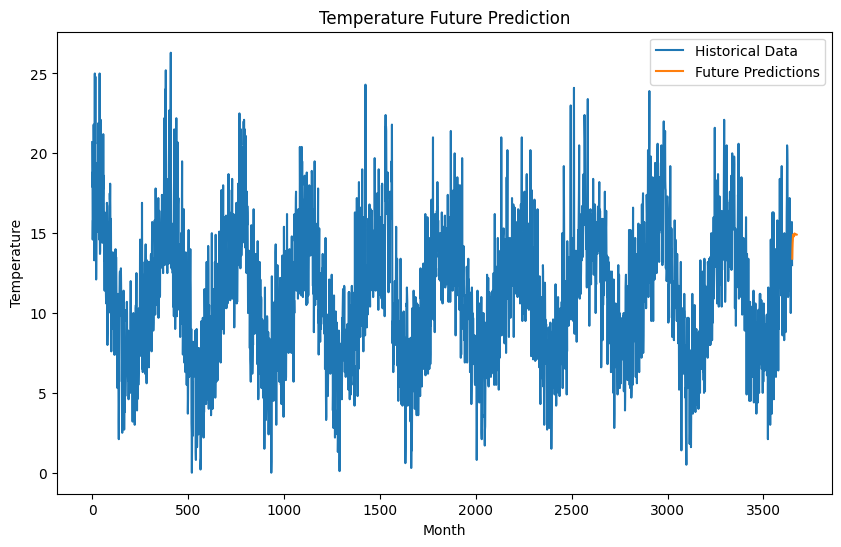

In [76]:
def predict_future(model, data, future_periods, seq_length):
    predictions = data[-seq_length:].tolist()
    predictions = [item for sublist in predictions for item in sublist]  # Flatten the list
    model.eval()
    for _ in range(future_periods):
        seq = torch.FloatTensor(predictions[-seq_length:])
        with torch.no_grad():
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                torch.zeros(1, 1, model.hidden_layer_size))
            predictions.append(model(seq).item())
    return predictions[seq_length:]

# Predict future values
future_periods = 24
predictions = predict_future(model, data_normalized, future_periods, seq_length)
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(data_normalized), label='Historical Data')
plt.plot(np.arange(len(data_normalized), len(data_normalized) + future_periods), predictions, label='Future Predictions')
plt.title('Temperature Future Prediction')
plt.xlabel('Month')
plt.ylabel('Temperature')
plt.legend()
plt.show()

---
### Questions
Answer the following questions in detail.

1. What is a Recurrent Neural Network (RNN)? Describe its key components and how they differ from those in a feedforward neural network.
2. Explain the purpose of the recurrent connection in an RNN. How does it enable the network to handle sequential data?
3. What are vanishing and exploding gradients, and how do they affect the training of RNNs?
4. Describe the Long Short-Term Memory (LSTM) network and its key components. How does it address the issues of vanishing and exploding gradients?
5. What is the purpose of the GRU (Gated Recurrent Unit) in RNNs? Compare it with LSTM.
6. Explain the role of the hidden state in an RNN. How is it updated during the training process?
7. What are some common evaluation metrics used to assess the performance of an RNN on a sequential task, such as language modeling or time series forecasting?
8. How does data preprocessing impact the performance of RNNs? Provide examples of preprocessing steps for text and time series data.
9. What is sequence-to-sequence learning in the context of RNNs, and what are its applications?
10. How can RNNs be used for anomaly detection in time series data? Describe the general approach.


### Answers

1. A Recurrent Neural Network (RNN) is a type of neural network that is designed to process sequential data.
The key components of an RNN are:
- recurrent connections which allow information to flow not only from the input layer to the output layer, but also from one hidden layer to another.
- hiddenstate which is a vector that represents the network's memory or context at a given step. It captures information from previous time steps and influences the predictions made at the current time step.
- time steps
- sequence length which is the number of time steps in the input sequence. It can vary depending on the task and the length of the input data.
Compared to a feedforward neural network, an RNN is able to capture temporal dependencies and process sequential data.The recurrent connections and hidden state allow the network to maintain memory of past inputs which makes it suitable for tasks that involve analyzing sequences.


2. The recurrent connection in an RNN helps maintain information about previous inputs in the sequence which effectively allows the network to process a form of memory. The recurrent connection enables the network to handle sequential data by maintaining a memory of previous inputs, understanding temporal dependencies, dynamically processing variable-length sequences, and generating sequential outputs based on both current and past inputs.


3. Vanishing ingredients a problem during the training of deep neural networks. It occurs when the gradients of the network's loss function become increasingly small as they are propagated back through the network during training. In RNNs, as the gradient is backpropagated through time, it can shrink exponentially with each time due to the multiplication of small weights.
Exploding gradients occurs when the gradients grow exponentially large during backpropagation. It can happen in RNNs when the weights involved in the calculations are large. The effect of this is that the weight updates become too large and cause the network parameters to diverge entirely.

4. Long Short-Term Memory (LSTM) networks are a type of RNN that is capable of learning long-term dependencies. The key components of LSTM include the cell state, the forget gate, the input gate, and the output gate. The cell state acts as the "memory" of the network, carrying information throughout the processing of the sequence. It runs straight down the entire chain of LSTM blocks, with only minor linear interactions. The forget gate decides what information is to be discarded from the cell state. It looks at the current input and the previous hidden state, and outputs a number between 0 and 1 for each number in the cell state, with 0 meaning "completely forget this" and 1 meaning "completely retain this". The  input gate updates the cell state with new information. It first decides which values will be updated using a sigmoid function, and then creates a vector of new candidate values that could be added to the state. The output gate decides what the next hidden state should be. The hidden state contains information on previous inputs. The core idea behind LSTMs is the constant error carousel, which allows gradients to flow back through time more or less unchanged. The linear nature of the cell state, with gates that only multiply by weights close to 0 or 1, makes it easier for the network to propagate gradients back through long sequences without the gradients vanishing or exploding. Moreover, by selectively forgetting information, the LSTM can prevent irrelevant information from impacting the cell state, thus maintaining the network's stability and preventing the gradients from exploding. Finally, the input and output gates regulate the flow of information into and out of the cell state. This selective updating mechanism allows the network to make minimal adjustments to the cell state, reducing the risk of the gradients vanishing as they are propagated back through time.


5. The Gated Recurrent Unit (GRU) is a type RNN architecture designed to solve the vanishing gradient problem, similar to LSTM model while retaining the ability to capture dependencies for long sequences. The purpose of GRU is to efficiently model sequential data by effectively remembering and forgetting information through its gating mechanisms. GRUs serve a similar purpose to LSTMs in addressing the vanishing gradient problem in RNNs but do so with a simpler architecture. LSTMs have a distinct cell state in addition to the hidden state, which allows for more precise control over the information flow. This can be advantageous for tasks that require the network to remember information over very long sequences. GRUs, with their single hidden state and simplified gating, blend the input and forget gates into a single update gate, potentially making them less effective at distinguishing between information that should be kept over long periods versus short-term information.

6. The hidden state in an RNN captures and retains information from previous time steps as the network processes a sequence. It serves as the network's memory, allowing it to exhibit dynamic temporal behavior and understand the context within a sequence. The hidden state stores information about the inputs that the network has processed so far in the sequence. This allows the RNN to make decisions based on both the current input and what it has seen previously. Moreover, the hidden state enables the RNN to process sequences of variable lengths and to maintain continuity across different parts of a sequence, even when they are processed in separate batches. The hidden state is updated at each time step as the RNN processes a sequence. At each time step, the RNN takes the current input and the hidden state from the previous time step as inputs. The inputs are then transformed using a set of weights and passed through an activation function. This transformation is designed to capture the relevant information from the current input and the previous state. The result of this transformation becomes the new hidden state. This updated state contains information from the current input as well as all previous inputs in the sequence. Depending on the architecture, the RNN can also generate an output at each time step, which can be based on the hidden state. This output can then be used for tasks like classification or prediction.


7. To evaluate the performance of RNNs on sequential tasks like language modeling. Perplexity is a measure of how well a probability model predicts a sample. In the context of language modeling, it measures how well the model predicts a sequence of words. Lower perplexity indicates a better model that is more certain about its predictions. Then, cross-entropy loss is a common loss function that measures the difference between the predicted probabilities and the actual distribution. Lower values indicate better performance. Lastly, BLEU Score can assess how natural the language produced by a model is. It compares the model's output with a set of reference sentences and calculates the similarity based on the overlap of n-grams. For time series forecasting, Mean Absolute Error (MAE) is used to measure the average magnitude of errors in a set of predictions, without considering their direction. Mean Squared Error (MSE)  is the square root of MSE. It is in the same units as the target variable and gives a relatively high weight to large errors. Like MSE, lower values indicate a better fit. R-squared (R²) measures how well the future data points are likely to be predicted by the model. It represents the proportion of the variance for the dependent variable that's explained by the independent variables in the model.


8. Data preprocessing can impact the performance of RNNs by ensuring the input data is in a suitable format for the model to process efficiently and effectively. Data preprocessing can enhance model accuracy, speed up training. Normalization helps in speeding up the training process by ensuring that all input features have similar scales. Data processing improves model accuracy by removing irrelevant information, allowing the RNN to focus on the significant features of the data. Moreover, data processing transforms categorical data into a numerical format that RNNs can understand. For text data, tokenazation splits text into smaller units; lowercasing converts all characters in the text to lowercase to reduce the vocabulary size; removing stop words and punctuation eliminates common words and punctuation that usually don’t add much meaning to the text; stemming/lemmatization reduces words to their base or root form anv vectorization converts tokens into numerical vectors. For time Series Data, normalization adjusts the scale of the data; differencing transforms the series into a stationary series, where the mean and variance are constant over time, by subtracting the previous observation from the current observation; feature engineering involves creating new input features based on the existing data and windowing/segmentation involves creating subsequences of the time series data that can be used as inputs for the RNN.

9. Sequence-to-sequence (Seq2Seq) is a machine learning concept where the model is trained to convert sequences from one domain to sequences in another domain, using RNNs or similar architectures like LSTMs or GRUs. This approach is suited for tasks where both the input and output are sequences that may have different lengths. A Seq2Seq model consists of an encoder and decoder. The encoder takes the input sequence and encodes it into a fixed-sized context vector, which is a representation of the input sequence's information. The encoder processes the input sequence step by step, updating its internal state and finally producing the context vector. The decoder generates the output sequence step by step. It is trained to predict the next element of the output sequence, given the previous elements and the context vector. The process continues until a special end-of-sequence token is produced or a maximum length is reached. Sequence-to-sequence learning is used in machine translation, speech recognition, text summarization, chatbots and conversational agents, question answering, and video captioning.


10. The general approach to using RNNs for anomaly detection in time series data involves the following steps:

- Data Preprocessing
Normalization: scale the time series data so that it has a specific mean and standard deviation, often 0 and 1, respectively.
Sequence Creation: Transform the time series into sequences that the RNN can process. Each sequence is a fixed-length window of consecutive data points.

- Model Architecture
Choose an appropriate RNN architecture. LSTM or GRU networks are popular choices due to their ability to capture long-term dependencies and mitigate the vanishing gradient problem.

- Training
Supervised Learning: if labeled data is available, the model can be trained directly to distinguish between normal and anomalous sequences.
Unsupervised Learning: more commonly, anomaly detection is treated as an unsupervised learning problem. The RNN is trained on normal data to predict the next value(s) in a sequence. The idea is to learn the normal patterns so that deviations from these patterns can be detected as anomalies.

- Anomaly Detection
Prediction Error: after training, the model is used to predict future values in the time series. The prediction error (e.g., the difference between the predicted and actual values) is then calculated. A high error indicates that the model's prediction deviates significantly from the actual data, suggesting an anomaly.
Thresholding: define a threshold for the prediction error to classify a data point or sequence as normal or anomalous. This threshold can be set based on domain knowledge, statistical analysis, or validation data.

- Post-Processing
Smoothing: apply smoothing techniques to the prediction errors to reduce noise and avoid false positives.
Temporal Analysis: Consider the temporal context of detected anomalies. For instance, a short burst of high errors might be treated differently from a prolonged period of slightly elevated errors.